# Diabetes Prediction Using Machine Learning
## A Comprehensive Analysis of the PIMA Indians Diabetes Dataset

**Objective**: Build and evaluate multiple machine learning models to predict diabetes onset 
based on diagnostic measurements.

**Dataset**: PIMA Indians Diabetes Database
- Source: National Institute of Diabetes and Digestive and Kidney Diseases
- Subjects: Pima Indian women aged 21+ years
- Size: 768 observations, 8 features
- Target: Binary classification (diabetic vs. non-diabetic)

**Key Questions**:
1. What factors are most predictive of diabetes?
2. How do different ML algorithms compare on this task?
3. What are the tradeoffs between false positives and false negatives?

### Import Libraries

In [2]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    precision_recall_curve, ConfusionMatrixDisplay
)

# Utilities
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


### Load Dataset

In [3]:
# Load the dataset
df = pd.read_csv('diabetes.csv')

print(f"Dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\n" + "="*50)
print("First 5 rows:")
df.head()

Dataset shape: 768 rows, 9 columns

First 5 rows:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Initial Data Overview

In [4]:
# Display basic information about the dataset
print("Dataset Information:")
print("="*50)
df.info()

print("\n" + "="*50)
print("Statistical Summary:")
print("="*50)
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Statistical Summary:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Check for Missing Values

In [5]:
# Check for missing values
print("Explicit Missing Values:")
print(df.isnull().sum())

print("\n" + "="*50)
print("\nInvestigating Zero Values (Potential Missing Data):")
print("="*50)

# For medical measurements, zero values are biologically impossible
# Check columns where zero doesn't make sense
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in zero_cols:
    zero_count = (df[col] == 0).sum()
    zero_pct = (zero_count / len(df)) * 100
    print(f"{col:20s}: {zero_count:4d} zeros ({zero_pct:5.2f}%)")

Explicit Missing Values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


Investigating Zero Values (Potential Missing Data):
Glucose             :    5 zeros ( 0.65%)
BloodPressure       :   35 zeros ( 4.56%)
SkinThickness       :  227 zeros (29.56%)
Insulin             :  374 zeros (48.70%)
BMI                 :   11 zeros ( 1.43%)


### Visualize Missing Data Pattern

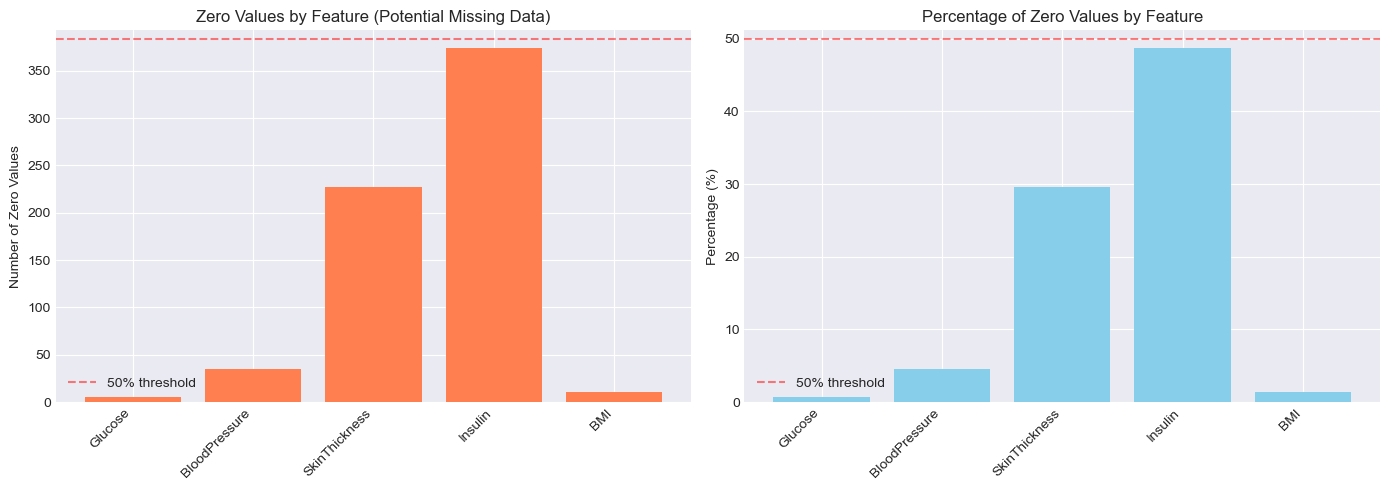


Key Observation:
Insulin and SkinThickness have very high percentages of zeros (missing data).
This will inform our preprocessing strategy.


In [51]:
# Visualize the missing data pattern
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count zeros in each column
zero_counts = df[zero_cols].apply(lambda x: (x == 0).sum())

# Bar plot of zero counts
axes[0].bar(range(len(zero_counts)), zero_counts.values, color='coral')
axes[0].set_xticks(range(len(zero_counts)))
axes[0].set_xticklabels(zero_counts.index, rotation=45, ha='right')
axes[0].set_ylabel('Number of Zero Values')
axes[0].set_title('Zero Values by Feature (Potential Missing Data)')
axes[0].axhline(y=len(df)*0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
axes[0].legend()

# Percentage plot
zero_pct = (zero_counts / len(df)) * 100
axes[1].bar(range(len(zero_pct)), zero_pct.values, color='skyblue')
axes[1].set_xticks(range(len(zero_pct)))
axes[1].set_xticklabels(zero_pct.index, rotation=45, ha='right')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Percentage of Zero Values by Feature')
axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
axes[1].legend()

plt.tight_layout()
plt.savefig('missing_data_pattern.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nKey Observation:")
print("Insulin and SkinThickness have very high percentages of zeros (missing data).")
print("This will inform our preprocessing strategy.")

### Target Variable Distribution

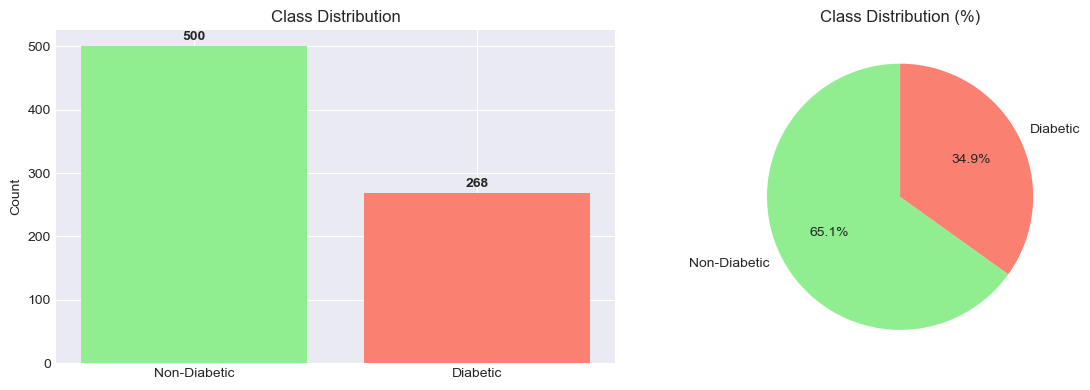


Class Distribution:
  Non-Diabetic (0): 500 (65.1%)
  Diabetic (1): 268 (34.9%)

Imbalance Ratio: 1.87:1

Note: Dataset is moderately imbalanced. We'll need to account for this in modeling.


In [52]:
# Analyze the target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
outcome_counts = df['Outcome'].value_counts()
axes[0].bar(['Non-Diabetic', 'Diabetic'], outcome_counts.values, color=['lightgreen', 'salmon'])
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution')
for i, v in enumerate(outcome_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(outcome_counts.values, labels=['Non-Diabetic', 'Diabetic'], 
            autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'salmon'])
axes[1].set_title('Class Distribution (%)')

plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate class imbalance ratio
imbalance_ratio = outcome_counts[0] / outcome_counts[1]
print(f"\nClass Distribution:")
print(f"  Non-Diabetic (0): {outcome_counts[0]} ({outcome_counts[0]/len(df)*100:.1f}%)")
print(f"  Diabetic (1): {outcome_counts[1]} ({outcome_counts[1]/len(df)*100:.1f}%)")
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
print("\nNote: Dataset is moderately imbalanced. We'll need to account for this in modeling.")

### Feature Distributions

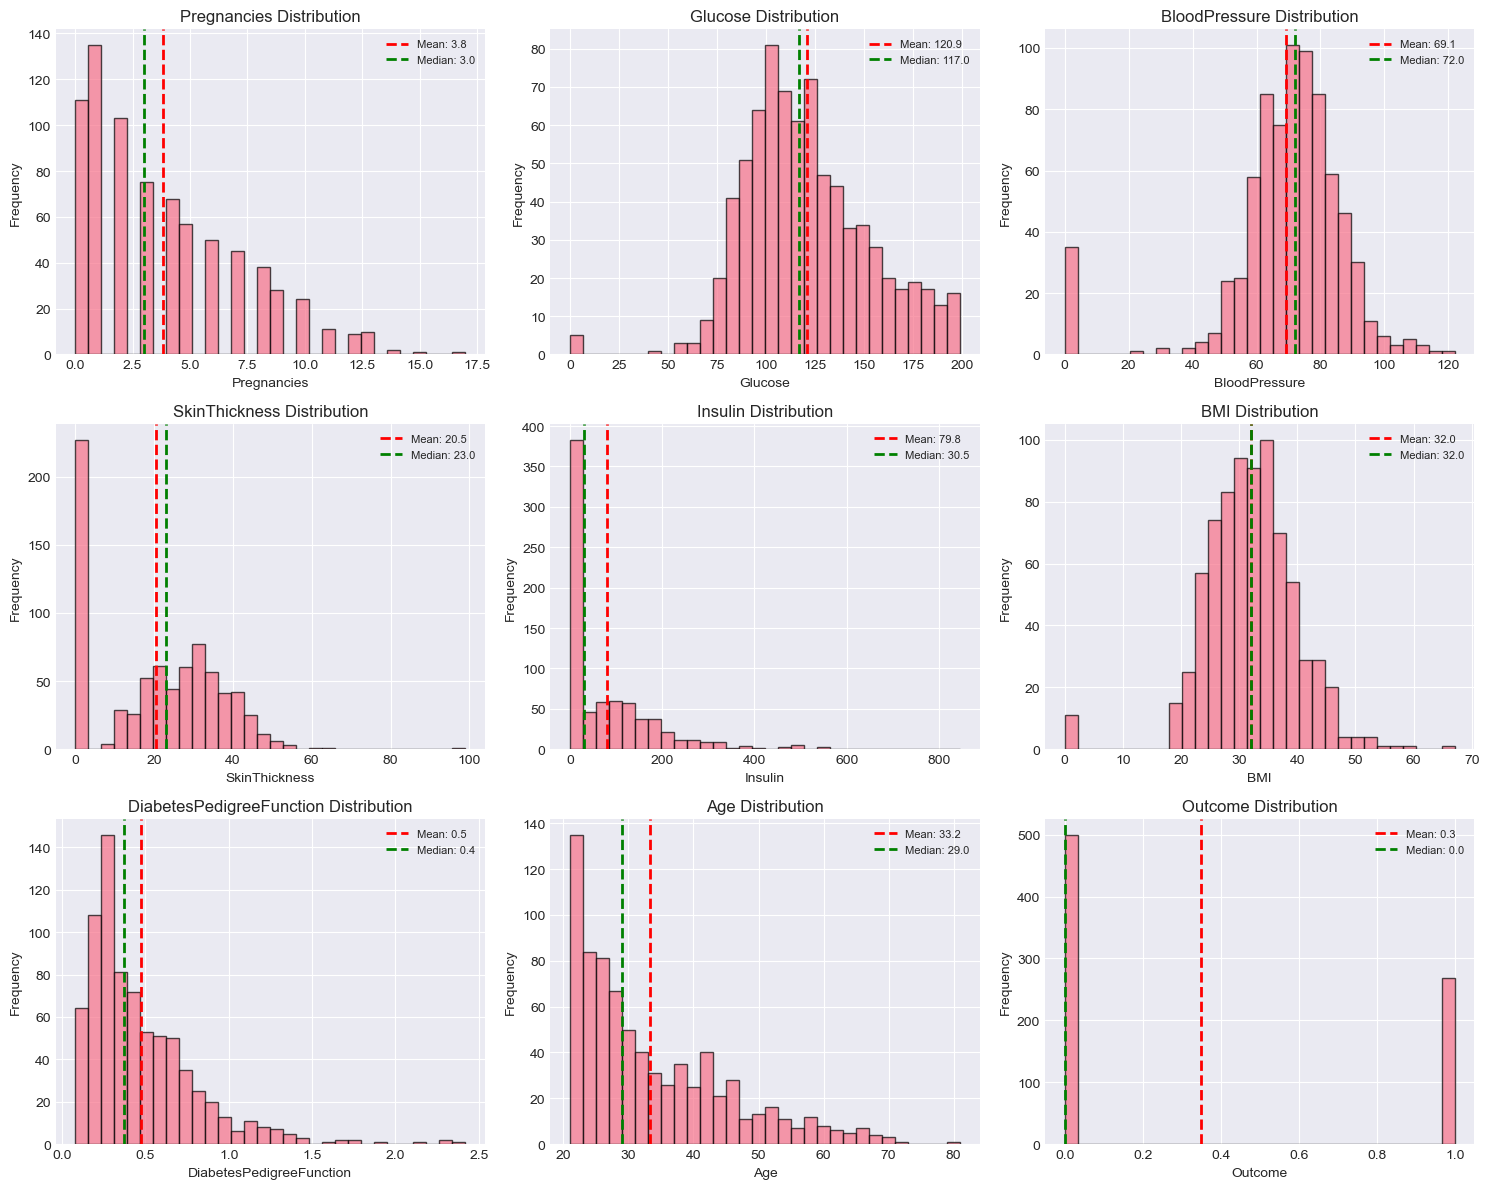

Observations:
- Several features show right-skewed distributions
- Zero values visible in Glucose, BloodPressure, SkinThickness, Insulin, BMI
- Age is right-skewed (younger population with some older outliers)


In [53]:
# Visualize distributions of all features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(df.columns):
    ax = axes[idx]
    
    # Plot distribution
    ax.hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(f'{col} Distribution')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    
    # Add statistics
    mean_val = df[col].mean()
    median_val = df[col].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Observations:")
print("- Several features show right-skewed distributions")
print("- Zero values visible in Glucose, BloodPressure, SkinThickness, Insulin, BMI")
print("- Age is right-skewed (younger population with some older outliers)")

### Correlation Analysis

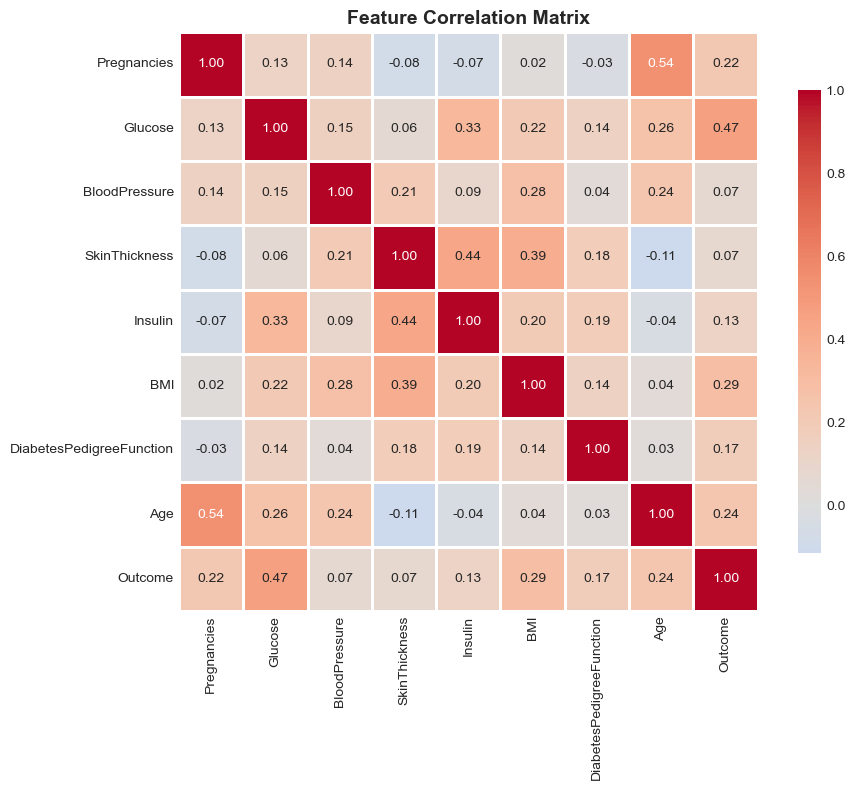

Correlations with Outcome (Diabetes):
Glucose                  : +0.467
BMI                      : +0.293
Age                      : +0.238
Pregnancies              : +0.222
DiabetesPedigreeFunction : +0.174
Insulin                  : +0.131
SkinThickness            : +0.075
BloodPressure            : +0.065

Key Insights:
- Glucose shows strongest positive correlation with diabetes
- BMI and Age also show moderate positive correlations
- No strong multicollinearity issues between features


In [54]:
# Correlation matrix
plt.figure(figsize=(10, 8))

# Calculate correlation matrix
corr_matrix = df.corr()

# Create heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print strongest correlations with target
print("Correlations with Outcome (Diabetes):")
print("="*50)
target_corr = corr_matrix['Outcome'].sort_values(ascending=False)
for feature, corr_val in target_corr.items():
    if feature != 'Outcome':
        print(f"{feature:25s}: {corr_val:+.3f}")

print("\nKey Insights:")
print("- Glucose shows strongest positive correlation with diabetes")
print("- BMI and Age also show moderate positive correlations")
print("- No strong multicollinearity issues between features")

### Compare Features by Outcome (Diabetic vs Non-Diabetic)

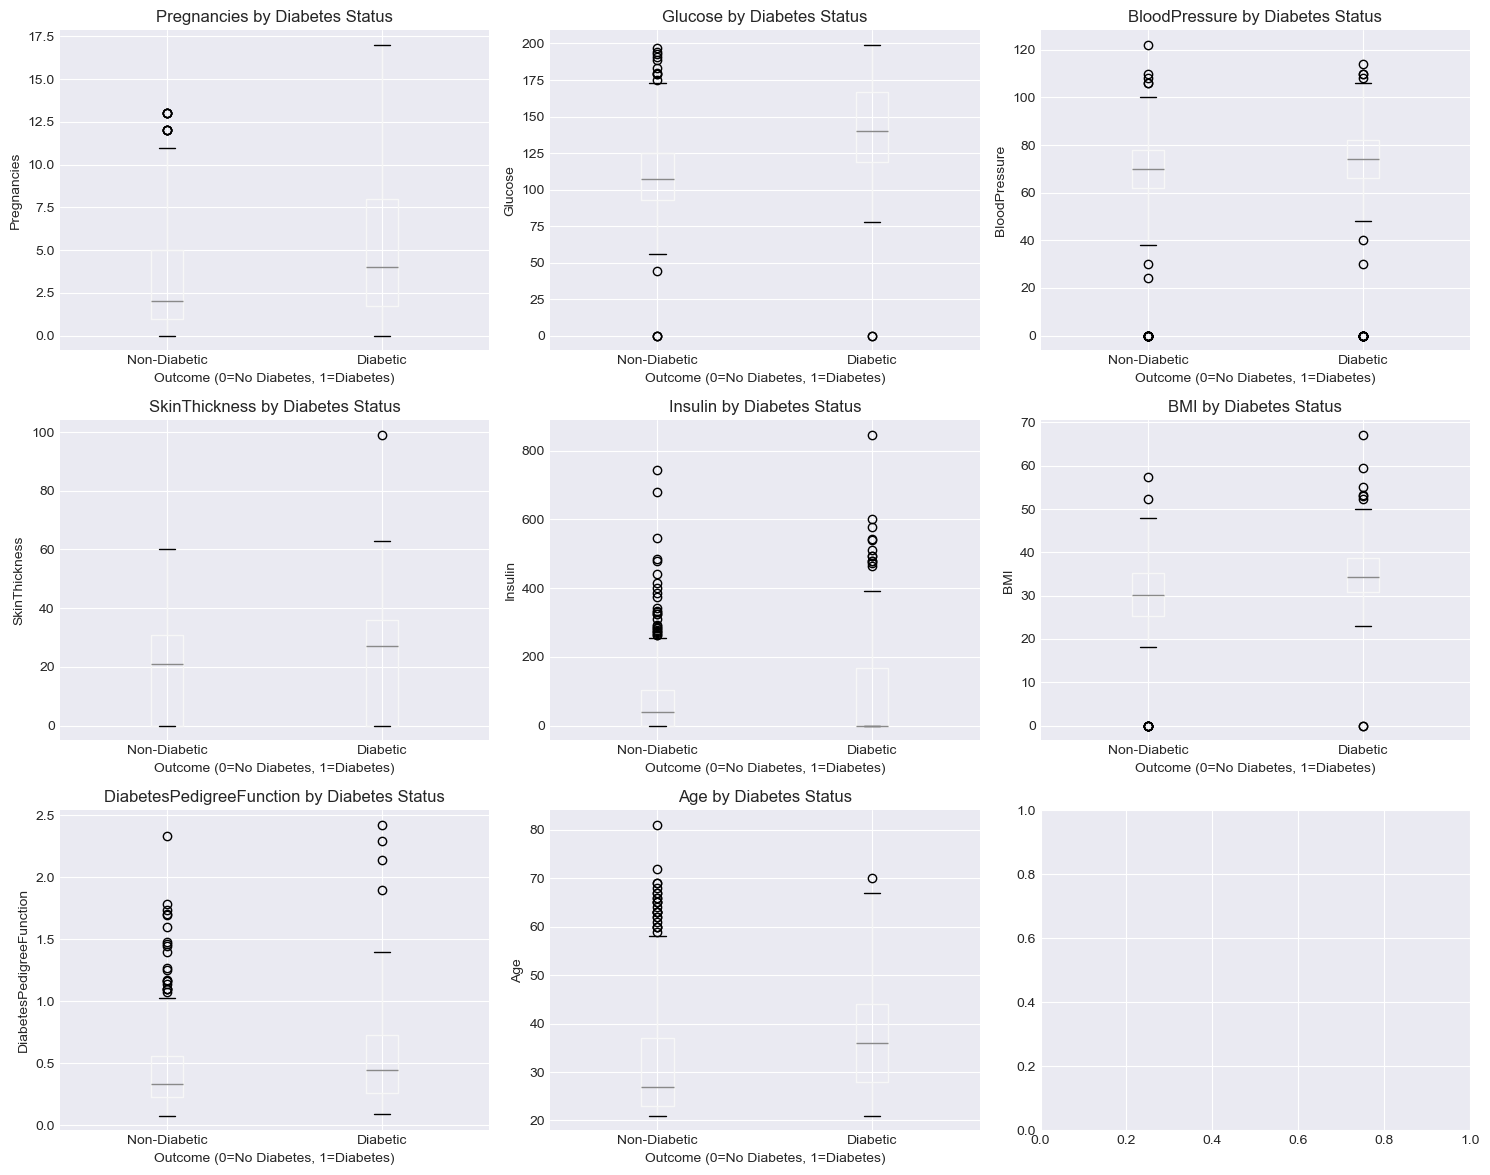

Visual Observations:
- Diabetic group shows higher median values for most features
- Glucose, BMI, and Age show clearest separation between groups
- This confirms these features should be strong predictors


In [55]:
# Box plots comparing diabetic vs non-diabetic groups
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

# Features to compare (exclude Outcome)
features = [col for col in df.columns if col != 'Outcome']

for idx, col in enumerate(features):
    ax = axes[idx]
    
    # Create box plot
    df.boxplot(column=col, by='Outcome', ax=ax)
    ax.set_title(f'{col} by Diabetes Status')
    ax.set_xlabel('Outcome (0=No Diabetes, 1=Diabetes)')
    ax.set_ylabel(col)
    plt.sca(ax)
    plt.xticks([1, 2], ['Non-Diabetic', 'Diabetic'])

# Remove the automatic title
plt.suptitle('')
plt.tight_layout()
plt.savefig('feature_comparison_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visual Observations:")
print("- Diabetic group shows higher median values for most features")
print("- Glucose, BMI, and Age show clearest separation between groups")
print("- This confirms these features should be strong predictors")

## Data Preprocessing

### Strategy for Handling Missing Values (Zeros)

Based on our EDA, we have identified zeros representing missing data in 5 features:
- **Insulin**: 48.7% missing - Very high! 
- **SkinThickness**: 29.6% missing - High
- **BloodPressure**: 4.6% missing - Moderate
- **Glucose**: 0.65% missing - Low
- **BMI**: 1.4% missing - Low

**Approach**:
1. Replace zeros with NaN for these 5 features
2. Use median imputation (robust to outliers)
3. Create a 'missingness indicator' feature for Insulin/SkinThickness
4. Document the impact of imputation on model performance

### Create Working Copy and Replace Zeros with NaN

In [56]:
# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# Replace zeros with NaN in columns where zero is biologically impossible
zero_not_allowed = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in zero_not_allowed:
    df_processed[col] = df_processed[col].replace(0, np.nan)

# Check missing values after replacement
print("Missing Values After Replacing Zeros with NaN:")
print("="*50)
missing_counts = df_processed.isnull().sum()
missing_pct = (missing_counts / len(df_processed)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))

print("\n✓ Zeros successfully replaced with NaN")

Missing Values After Replacing Zeros with NaN:
               Missing_Count  Percentage
Insulin                  374   48.697917
SkinThickness            227   29.557292
BloodPressure             35    4.557292
BMI                       11    1.432292
Glucose                    5    0.651042

✓ Zeros successfully replaced with NaN


### Visualize Missing Data Pattern

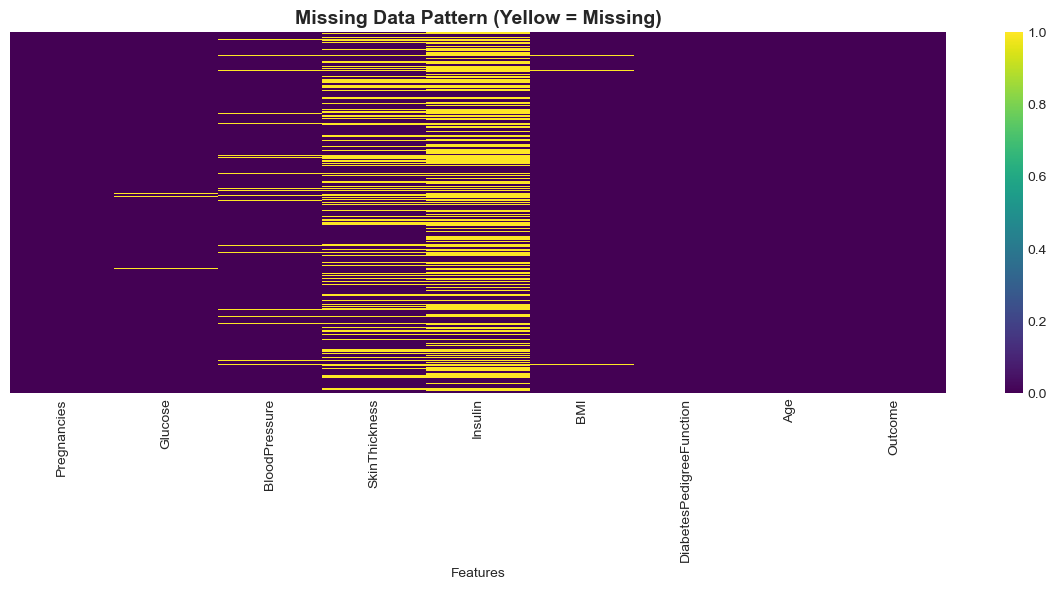

Note: Yellow bars show missing values. Insulin and SkinThickness show the most missing data.


In [57]:
# Visualize missing data pattern before imputation
plt.figure(figsize=(12, 6))

# Create a boolean mask for missing values
missing_mask = df_processed.isnull()

# Plot heatmap
sns.heatmap(missing_mask, cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Data Pattern (Yellow = Missing)', fontsize=14, fontweight='bold')
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('missing_data_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Note: Yellow bars show missing values. Insulin and SkinThickness show the most missing data.")

### Create Missingness Indicators

In [13]:
# Create binary indicators for features with high missingness
# These can be informative features themselves

df_processed['Insulin_Missing'] = df_processed['Insulin'].isnull().astype(int)
df_processed['SkinThickness_Missing'] = df_processed['SkinThickness'].isnull().astype(int)

print("Missingness Indicator Features Created:")
print("="*50)
print(f"Insulin_Missing: {df_processed['Insulin_Missing'].sum()} cases")
print(f"SkinThickness_Missing: {df_processed['SkinThickness_Missing'].sum()} cases")

# Check correlation of missingness with outcome
print("\nCorrelation of Missingness with Diabetes:")
print(f"Insulin_Missing: {df_processed['Insulin_Missing'].corr(df_processed['Outcome']):.3f}")
print(f"SkinThickness_Missing: {df_processed['SkinThickness_Missing'].corr(df_processed['Outcome']):.3f}")

print("\n✓ Missingness indicators created")

Missingness Indicator Features Created:
Insulin_Missing: 374 cases
SkinThickness_Missing: 227 cases

Correlation of Missingness with Diabetes:
Insulin_Missing: 0.041
SkinThickness_Missing: 0.053

✓ Missingness indicators created


### Impute Missing Values

In [14]:
# Separate features and target
X = df_processed.drop('Outcome', axis=1)
y = df_processed['Outcome']

print("Shape before imputation:")
print(f"X: {X.shape}, y: {y.shape}")

# Use median imputation for the features with missing values
# Median is more robust to outliers than mean
imputer = SimpleImputer(strategy='median')

# Get column names before imputation
column_names = X.columns

# Fit and transform
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame to preserve column names
X_imputed = pd.DataFrame(X_imputed, columns=column_names)

print("\n" + "="*50)
print("Missing Values After Imputation:")
print("="*50)
print(X_imputed.isnull().sum().sum(), "missing values remaining")

print("\n✓ Missing values successfully imputed using median strategy")

Shape before imputation:
X: (768, 10), y: (768,)

Missing Values After Imputation:
0 missing values remaining

✓ Missing values successfully imputed using median strategy


### Compare Distributions Before/After Imputation

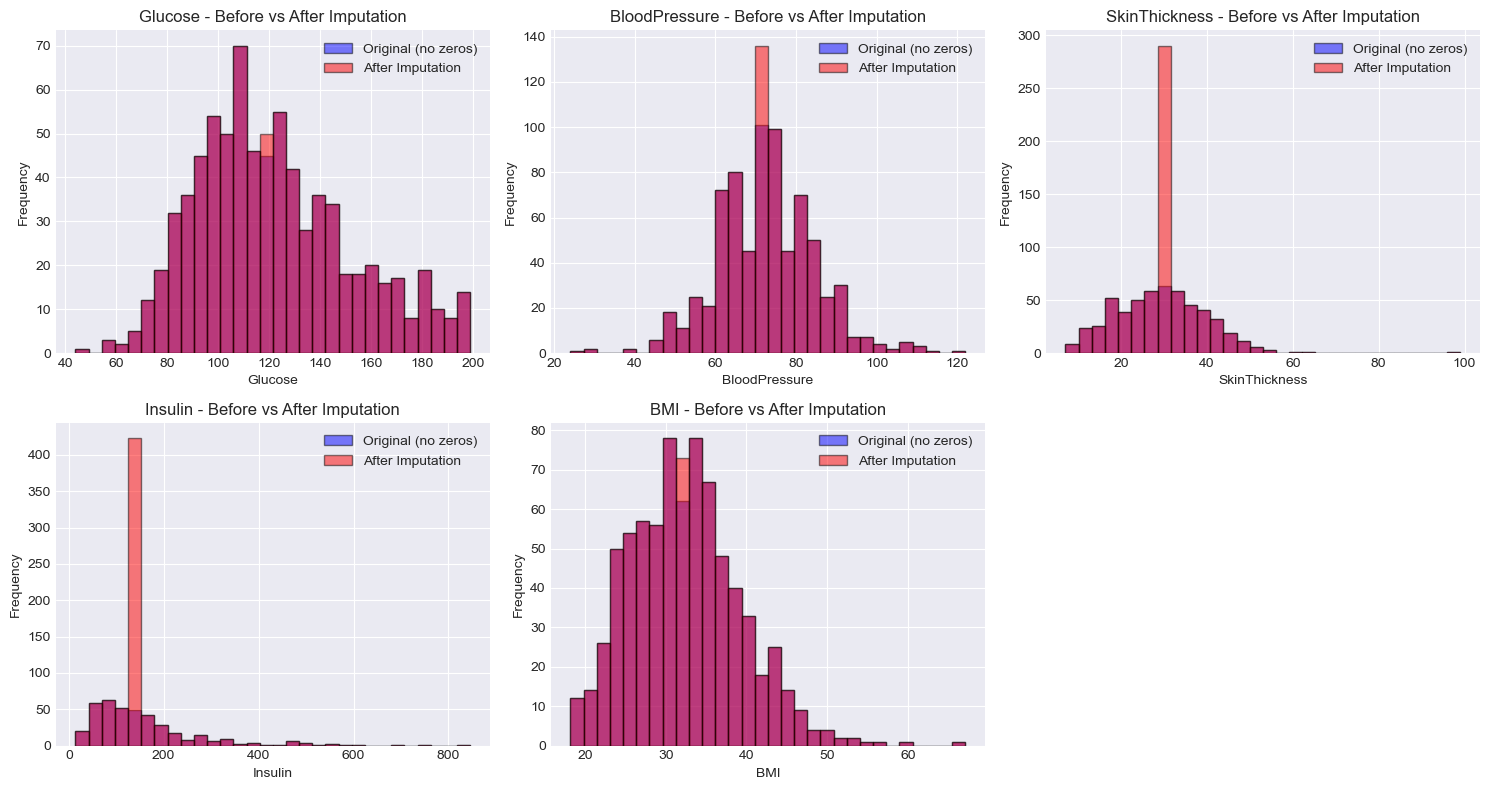

Observation: Imputation preserved the general distribution shape while filling gaps.


In [58]:
# Compare distributions for imputed features
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

# Features that were imputed
imputed_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for idx, col in enumerate(imputed_features):
    ax = axes[idx]
    
    # Original data (excluding zeros/NaN)
    original_valid = df[col][df[col] > 0]
    
    # Imputed data
    imputed_data = X_imputed[col]
    
    # Plot both distributions
    ax.hist(original_valid, bins=30, alpha=0.5, label='Original (no zeros)', color='blue', edgecolor='black')
    ax.hist(imputed_data, bins=30, alpha=0.5, label='After Imputation', color='red', edgecolor='black')
    
    ax.set_title(f'{col} - Before vs After Imputation')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig('imputation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Observation: Imputation preserved the general distribution shape while filling gaps.")

### Train-Test Split

In [16]:
# Split data into training and testing sets
# Use stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y
)

print("Data Split Complete:")
print("="*50)
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_imputed)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_imputed)*100:.1f}%)")

print("\nClass distribution in training set:")
print(y_train.value_counts())
print(f"Ratio: {y_train.value_counts()[0]/y_train.value_counts()[1]:.2f}:1")

print("\nClass distribution in test set:")
print(y_test.value_counts())
print(f"Ratio: {y_test.value_counts()[0]/y_test.value_counts()[1]:.2f}:1")

print("\n✓ Stratified split maintains class distribution in both sets")

Data Split Complete:
Training set: 614 samples (79.9%)
Test set: 154 samples (20.1%)

Class distribution in training set:
Outcome
0    400
1    214
Name: count, dtype: int64
Ratio: 1.87:1

Class distribution in test set:
Outcome
0    100
1     54
Name: count, dtype: int64
Ratio: 1.85:1

✓ Stratified split maintains class distribution in both sets


### Feature Scaling

In [17]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier interpretation later
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature Scaling Complete:")
print("="*50)
print("Scaling method: StandardScaler (z-score normalization)")
print("Formula: z = (x - μ) / σ")

print("\nSample of scaled training data:")
print(X_train_scaled.head())

print("\nScaled feature statistics (should be ~0 mean, ~1 std):")
print(X_train_scaled.describe().loc[['mean', 'std']])

print("\n✓ Features successfully scaled")

Feature Scaling Complete:
Scaling method: StandardScaler (z-score normalization)
Formula: z = (x - μ) / σ

Sample of scaled training data:
     Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
353    -0.851355 -1.056427      -0.826740      -1.918187 -1.203361 -0.769477   
711     0.356576  0.144399       0.477772      -0.229874 -1.470195 -0.417498   
373    -0.549372 -0.556083      -1.152868       1.233330 -0.555335  0.359790   
46     -0.851355  0.811525      -1.315932      -0.004766 -0.161437 -0.402832   
682    -1.153338 -0.889646      -0.663676       1.120776 -0.415565  1.782373   

     DiabetesPedigreeFunction       Age  Insulin_Missing  \
353                  0.310794 -0.792169        -0.946077   
711                 -0.116439  0.561034        -0.946077   
373                 -0.764862 -0.707594        -0.946077   
46                   0.262314 -0.369293         1.056996   
682                 -0.337630 -0.961320        -0.946077   

     SkinThickness_

### Preprocessing Summary

## Preprocessing Summary

### What Has Been Done:
1. ✓ Identified and replaced biologically impossible zeros with NaN
2. ✓ Created missingness indicator features for Insulin and SkinThickness
3. ✓ Imputed missing values using median strategy (robust to outliers)
4. ✓ Performed stratified train-test split (80-20) maintaining class distribution
5. ✓ Applied standard scaling to normalize features

### Dataset Ready for Modeling:
- Training set: 614 samples (10 features)
- Test set: 154 samples (10 features)
- Features: 8 original + 2 missingness indicators
- All features scaled to mean=0, std=1
- Class balance maintained in both sets

### Next Steps:
- Train multiple classification algorithms
- Use cross-validation for robust evaluation
- Compare model performance
- Select best model and tune hyperparameters

## Model Development and Evaluation

### Approach:
Train and compare 6 different classification algorithms:
1. **Logistic Regression** - Linear baseline model
2. **Decision Tree** - Non-linear, interpretable
3. **Random Forest** - Ensemble of trees, reduces overfitting
4. **Gradient Boosting** - Sequential ensemble, often high performance
5. **Support Vector Machine (SVM)** - Finds optimal decision boundary
6. **K-Nearest Neighbors (KNN)** - Instance-based learning

### Evaluation Strategy:
- Use 5-fold stratified cross-validation
- Track multiple metrics: Accuracy, Precision, Recall, F1-Score, ROC-AUC
- Focus on Recall (minimize false negatives) for medical diagnosis
- Compare computational efficiency

### Initialize Models

In [18]:
# Initialize all models with default parameters
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'SVM': SVC(random_state=RANDOM_STATE, probability=True),
    'KNN': KNeighborsClassifier()
}

print("Models Initialized:")
print("="*50)
for name in models.keys():
    print(f"✓ {name}")

Models Initialized:
✓ Logistic Regression
✓ Decision Tree
✓ Random Forest
✓ Gradient Boosting
✓ SVM
✓ KNN


### Cross-Validation Function

In [19]:
def evaluate_model_cv(model, X, y, cv=5):
    """
    Evaluate a model using cross-validation
    
    Parameters:
    -----------
    model : sklearn estimator
        The model to evaluate
    X : array-like
        Feature matrix
    y : array-like
        Target vector
    cv : int
        Number of cross-validation folds
    
    Returns:
    --------
    dict : Dictionary containing mean scores and std deviations
    """
    # Define scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    
    # Setup stratified k-fold
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    results = {}
    
    for metric_name, metric in scoring.items():
        scores = cross_val_score(model, X, y, cv=skf, scoring=metric)
        results[f'{metric_name}_mean'] = scores.mean()
        results[f'{metric_name}_std'] = scores.std()
    
    return results

print("✓ Cross-validation function defined")

✓ Cross-validation function defined


### Train and Evaluate All Models

In [20]:
# Store results
cv_results = {}
training_times = {}

print("Training Models with 5-Fold Cross-Validation...")
print("="*70)

import time

for name, model in models.items():
    print(f"\n{name}...")
    
    # Time the training
    start_time = time.time()
    
    # Evaluate with cross-validation
    results = evaluate_model_cv(model, X_train_scaled, y_train, cv=5)
    
    end_time = time.time()
    training_time = end_time - start_time
    
    # Store results
    cv_results[name] = results
    training_times[name] = training_time
    
    # Print results
    print(f"  Accuracy:  {results['accuracy_mean']:.4f} (±{results['accuracy_std']:.4f})")
    print(f"  Precision: {results['precision_mean']:.4f} (±{results['precision_std']:.4f})")
    print(f"  Recall:    {results['recall_mean']:.4f} (±{results['recall_std']:.4f})")
    print(f"  F1-Score:  {results['f1_mean']:.4f} (±{results['f1_std']:.4f})")
    print(f"  ROC-AUC:   {results['roc_auc_mean']:.4f} (±{results['roc_auc_std']:.4f})")
    print(f"  Time:      {training_time:.3f}s")

print("\n" + "="*70)
print("✓ All models trained and evaluated")

Training Models with 5-Fold Cross-Validation...

Logistic Regression...
  Accuracy:  0.7899 (±0.0145)
  Precision: 0.7605 (±0.0569)
  Recall:    0.5888 (±0.0309)
  F1-Score:  0.6614 (±0.0155)
  ROC-AUC:   0.8433 (±0.0161)
  Time:      0.072s

Decision Tree...
  Accuracy:  0.6840 (±0.0219)
  Precision: 0.5441 (±0.0280)
  Recall:    0.5607 (±0.0683)
  F1-Score:  0.5512 (±0.0467)
  ROC-AUC:   0.6553 (±0.0312)
  Time:      0.056s

Random Forest...
  Accuracy:  0.7606 (±0.0218)
  Precision: 0.6935 (±0.0485)
  Recall:    0.5704 (±0.0427)
  F1-Score:  0.6240 (±0.0295)
  ROC-AUC:   0.8170 (±0.0223)
  Time:      1.349s

Gradient Boosting...
  Accuracy:  0.7443 (±0.0171)
  Precision: 0.6559 (±0.0472)
  Recall:    0.5746 (±0.0412)
  F1-Score:  0.6101 (±0.0183)
  ROC-AUC:   0.8190 (±0.0178)
  Time:      1.422s

SVM...
  Accuracy:  0.7687 (±0.0078)
  Precision: 0.7189 (±0.0311)
  Recall:    0.5609 (±0.0653)
  F1-Score:  0.6263 (±0.0318)
  ROC-AUC:   0.8296 (±0.0203)
  Time:      0.312s

KNN...
  Ac

### Visualize Cross-Validation Results

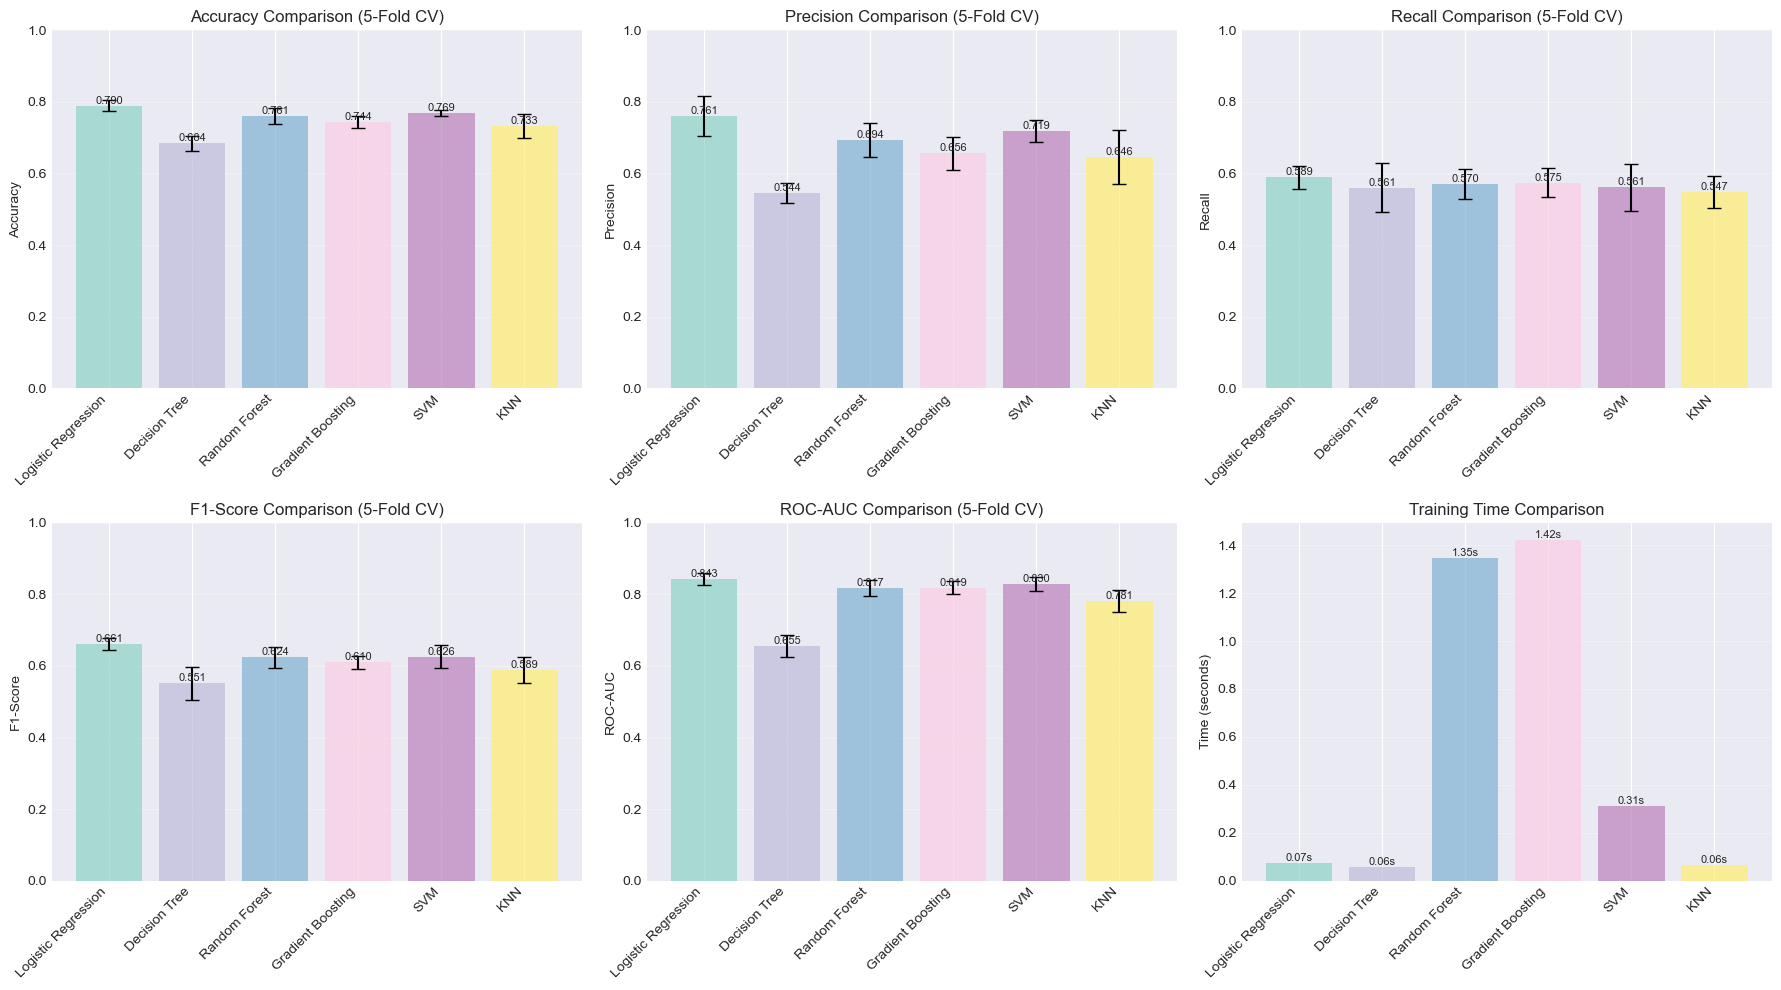

In [59]:
# Create a comprehensive comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

# Metrics to plot
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# Plot each metric
for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx]
    
    # Extract mean and std for this metric
    model_names = list(cv_results.keys())
    means = [cv_results[name][f'{metric}_mean'] for name in model_names]
    stds = [cv_results[name][f'{metric}_std'] for name in model_names]
    
    # Create bar plot
    x_pos = np.arange(len(model_names))
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
                  color=plt.cm.Set3(np.linspace(0, 1, len(model_names))))
    
    # Customize
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} Comparison (5-Fold CV)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, mean) in enumerate(zip(bars, means)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.3f}',
                ha='center', va='bottom', fontsize=8)

# Training time comparison
ax = axes[5]
model_names = list(training_times.keys())
times = list(training_times.values())

bars = ax.bar(range(len(model_names)), times, alpha=0.7,
              color=plt.cm.Set3(np.linspace(0, 1, len(model_names))))
ax.set_ylabel('Time (seconds)')
ax.set_title('Training Time Comparison')
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{time_val:.2f}s',
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

### Create Summary Table

In [22]:
# Create a comprehensive results table
summary_data = []

for name in cv_results.keys():
    row = {
        'Model': name,
        'Accuracy': f"{cv_results[name]['accuracy_mean']:.4f} ± {cv_results[name]['accuracy_std']:.4f}",
        'Precision': f"{cv_results[name]['precision_mean']:.4f} ± {cv_results[name]['precision_std']:.4f}",
        'Recall': f"{cv_results[name]['recall_mean']:.4f} ± {cv_results[name]['recall_std']:.4f}",
        'F1-Score': f"{cv_results[name]['f1_mean']:.4f} ± {cv_results[name]['f1_std']:.4f}",
        'ROC-AUC': f"{cv_results[name]['roc_auc_mean']:.4f} ± {cv_results[name]['roc_auc_std']:.4f}",
        'Time (s)': f"{training_times[name]:.3f}"
    }
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

print("Model Performance Summary (5-Fold Cross-Validation):")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)

Model Performance Summary (5-Fold Cross-Validation):
              Model        Accuracy       Precision          Recall        F1-Score         ROC-AUC Time (s)
Logistic Regression 0.7899 ± 0.0145 0.7605 ± 0.0569 0.5888 ± 0.0309 0.6614 ± 0.0155 0.8433 ± 0.0161    0.072
      Decision Tree 0.6840 ± 0.0219 0.5441 ± 0.0280 0.5607 ± 0.0683 0.5512 ± 0.0467 0.6553 ± 0.0312    0.056
      Random Forest 0.7606 ± 0.0218 0.6935 ± 0.0485 0.5704 ± 0.0427 0.6240 ± 0.0295 0.8170 ± 0.0223    1.349
  Gradient Boosting 0.7443 ± 0.0171 0.6559 ± 0.0472 0.5746 ± 0.0412 0.6101 ± 0.0183 0.8190 ± 0.0178    1.422
                SVM 0.7687 ± 0.0078 0.7189 ± 0.0311 0.5609 ± 0.0653 0.6263 ± 0.0318 0.8296 ± 0.0203    0.312
                KNN 0.7329 ± 0.0344 0.6456 ± 0.0760 0.5471 ± 0.0450 0.5888 ± 0.0372 0.7809 ± 0.0308    0.065


### Identify Best Models

In [23]:
# Find best model for each metric
print("\nBest Models by Metric:")
print("="*50)

metrics_to_check = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for metric in metrics_to_check:
    scores = [(name, cv_results[name][f'{metric}_mean']) for name in cv_results.keys()]
    best_model, best_score = max(scores, key=lambda x: x[1])
    print(f"{metric.upper():15s}: {best_model:20s} ({best_score:.4f})")

# Overall best model (based on F1-score as balance between precision and recall)
f1_scores = [(name, cv_results[name]['f1_mean']) for name in cv_results.keys()]
best_overall, best_f1 = max(f1_scores, key=lambda x: x[1])

print("\n" + "="*50)
print(f"RECOMMENDED MODEL: {best_overall}")
print(f"F1-Score: {best_f1:.4f}")
print("="*50)
print("\nRationale: F1-Score balances precision and recall,")
print("which is crucial for medical diagnosis where both")
print("false positives and false negatives have consequences.")


Best Models by Metric:
ACCURACY       : Logistic Regression  (0.7899)
PRECISION      : Logistic Regression  (0.7605)
RECALL         : Logistic Regression  (0.5888)
F1             : Logistic Regression  (0.6614)
ROC_AUC        : Logistic Regression  (0.8433)

RECOMMENDED MODEL: Logistic Regression
F1-Score: 0.6614

Rationale: F1-Score balances precision and recall,
which is crucial for medical diagnosis where both
false positives and false negatives have consequences.


### Train Best Model on Full Training Set

In [24]:
# Train the best model on the full training set
best_model = models[best_overall]
best_model.fit(X_train_scaled, y_train)

print(f"Training {best_overall} on full training set...")
print("="*50)

# Make predictions on training set
y_train_pred = best_model.predict(X_train_scaled)
y_train_pred_proba = best_model.predict_proba(X_train_scaled)[:, 1]

# Make predictions on test set
y_test_pred = best_model.predict(X_test_scaled)
y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate on training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)

# Evaluate on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print("\nTraining Set Performance:")
print(f"  Accuracy:  {train_accuracy:.4f}")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall:    {train_recall:.4f}")
print(f"  F1-Score:  {train_f1:.4f}")
print(f"  ROC-AUC:   {train_roc_auc:.4f}")

print("\nTest Set Performance:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print(f"  ROC-AUC:   {test_roc_auc:.4f}")

print("\n✓ Model trained and evaluated on hold-out test set")

Training Logistic Regression on full training set...

Training Set Performance:
  Accuracy:  0.7964
  Precision: 0.7633
  Recall:    0.6028
  F1-Score:  0.6736
  ROC-AUC:   0.8526

Test Set Performance:
  Accuracy:  0.6948
  Precision: 0.5714
  Recall:    0.5185
  F1-Score:  0.5437
  ROC-AUC:   0.8163

✓ Model trained and evaluated on hold-out test set


### Confusion Matrix

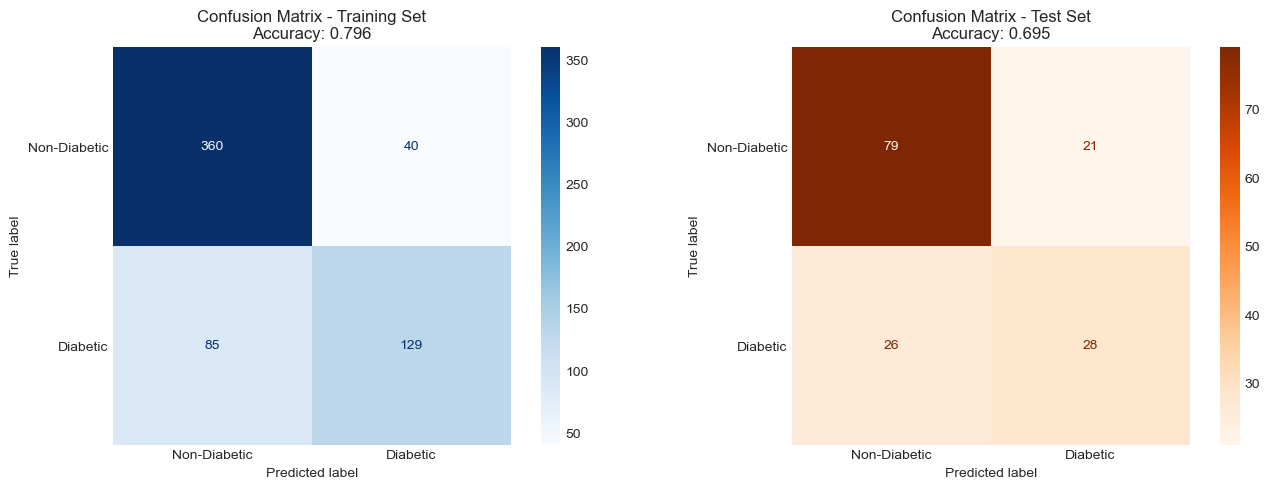

Test Set Confusion Matrix Breakdown:
True Negatives:  79 (Correctly predicted non-diabetic)
False Positives: 21 (Incorrectly predicted diabetic)
False Negatives: 26 (Incorrectly predicted non-diabetic)
True Positives:  28 (Correctly predicted diabetic)

Interpretation:
- The model correctly identified 28 out of 54 diabetic cases
- 26 diabetic cases were missed (false negatives)
- 21 non-diabetic cases were incorrectly flagged (false positives)


In [60]:
# Create confusion matrices for both training and test sets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                     display_labels=['Non-Diabetic', 'Diabetic'])
disp_train.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Confusion Matrix - Training Set\nAccuracy: {train_accuracy:.3f}')
axes[0].grid(False)

# Test set confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                    display_labels=['Non-Diabetic', 'Diabetic'])
disp_test.plot(ax=axes[1], cmap='Oranges', values_format='d')
axes[1].set_title(f'Confusion Matrix - Test Set\nAccuracy: {test_accuracy:.3f}')
axes[1].grid(False)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed breakdown for test set
print("Test Set Confusion Matrix Breakdown:")
print("="*50)
print(f"True Negatives:  {cm_test[0,0]} (Correctly predicted non-diabetic)")
print(f"False Positives: {cm_test[0,1]} (Incorrectly predicted diabetic)")
print(f"False Negatives: {cm_test[1,0]} (Incorrectly predicted non-diabetic)")
print(f"True Positives:  {cm_test[1,1]} (Correctly predicted diabetic)")

print("\nInterpretation:")
print(f"- The model correctly identified {cm_test[1,1]} out of {cm_test[1,0]+cm_test[1,1]} diabetic cases")
print(f"- {cm_test[1,0]} diabetic cases were missed (false negatives)")
print(f"- {cm_test[0,1]} non-diabetic cases were incorrectly flagged (false positives)")

### Classification Report

In [26]:
# Generate detailed classification report
print("Detailed Classification Report - Test Set:")
print("="*60)
print(classification_report(y_test, y_test_pred, 
                          target_names=['Non-Diabetic', 'Diabetic'],
                          digits=4))

print("\nMetric Definitions:")
print("-" * 60)
print("Precision: Of all predicted diabetic cases, what % were correct?")
print("Recall:    Of all actual diabetic cases, what % did we catch?")
print("F1-Score:  Harmonic mean of precision and recall")
print("Support:   Number of actual cases in each class")

Detailed Classification Report - Test Set:
              precision    recall  f1-score   support

Non-Diabetic     0.7524    0.7900    0.7707       100
    Diabetic     0.5714    0.5185    0.5437        54

    accuracy                         0.6948       154
   macro avg     0.6619    0.6543    0.6572       154
weighted avg     0.6889    0.6948    0.6911       154


Metric Definitions:
------------------------------------------------------------
Precision: Of all predicted diabetic cases, what % were correct?
Recall:    Of all actual diabetic cases, what % did we catch?
F1-Score:  Harmonic mean of precision and recall
Support:   Number of actual cases in each class


### ROC Curve

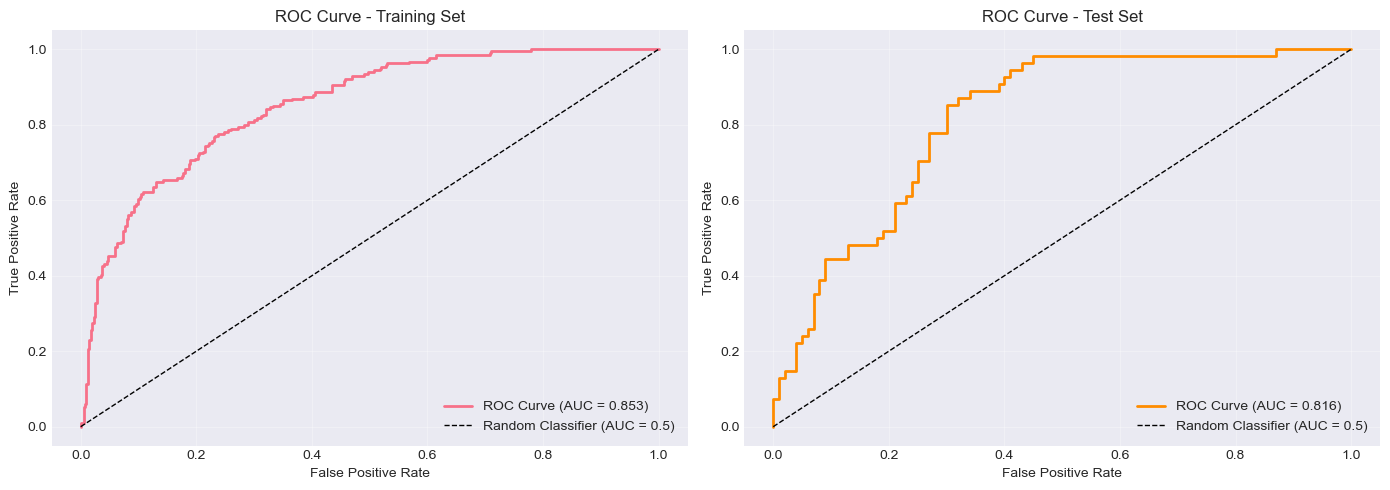

ROC Curve Interpretation:
Training AUC: 0.8526
Test AUC:     0.8163

The AUC of 0.816 indicates good discriminative ability.
AUC > 0.8 is considered excellent for medical diagnostic models.


In [61]:
# Plot ROC curves for both sets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
axes[0].plot(fpr_train, tpr_train, linewidth=2, label=f'ROC Curve (AUC = {train_roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.5)')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Training Set')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# Test set ROC
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_proba)
axes[1].plot(fpr_test, tpr_test, linewidth=2, label=f'ROC Curve (AUC = {test_roc_auc:.3f})', color='darkorange')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.5)')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Test Set')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC Curve Interpretation:")
print("="*60)
print(f"Training AUC: {train_roc_auc:.4f}")
print(f"Test AUC:     {test_roc_auc:.4f}")
print(f"\nThe AUC of {test_roc_auc:.3f} indicates good discriminative ability.")
print("AUC > 0.8 is considered excellent for medical diagnostic models.")

### Precision-Recall Curve

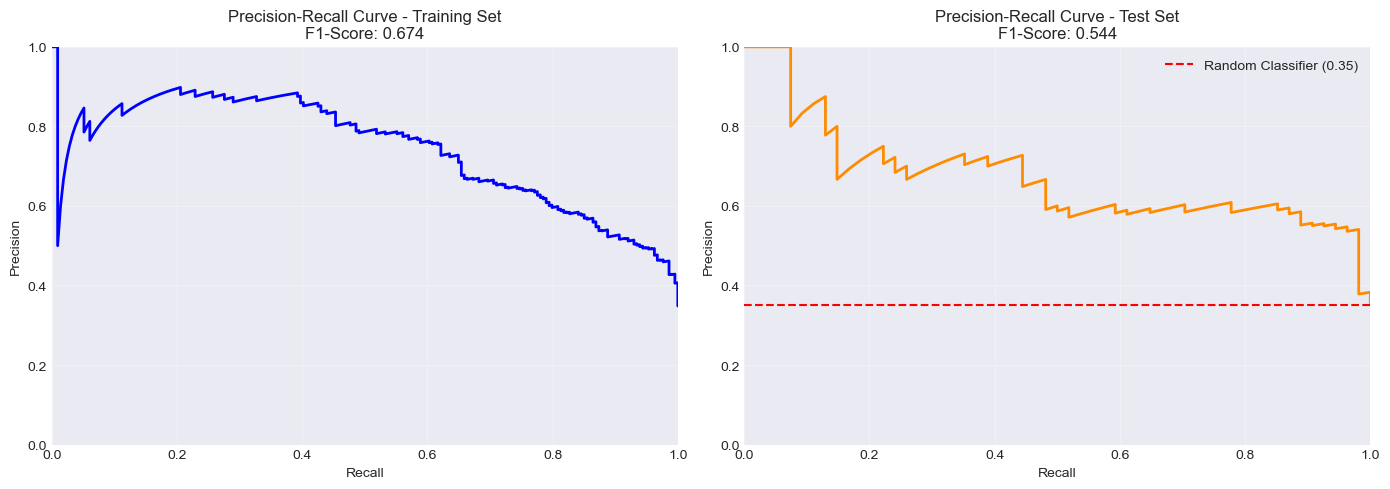

Precision-Recall Trade-off:
For medical diagnosis, we can adjust the decision threshold to:
- Increase RECALL (catch more diabetic cases) → more false positives
- Increase PRECISION (reduce false alarms) → more false negatives

Current threshold (0.5): Precision=0.571, Recall=0.519


In [62]:
# Precision-Recall curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred_proba)
axes[0].plot(recall_train, precision_train, linewidth=2, color='blue')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title(f'Precision-Recall Curve - Training Set\nF1-Score: {train_f1:.3f}')
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Test set
precision_test, recall_test, pr_thresholds = precision_recall_curve(y_test, y_test_pred_proba)
axes[1].plot(recall_test, precision_test, linewidth=2, color='darkorange')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title(f'Precision-Recall Curve - Test Set\nF1-Score: {test_f1:.3f}')
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

# Add baseline (random classifier performance for imbalanced data)
baseline_precision = y_test.sum() / len(y_test)
axes[1].axhline(y=baseline_precision, color='red', linestyle='--', 
                label=f'Random Classifier ({baseline_precision:.2f})')
axes[1].legend()

plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Precision-Recall Trade-off:")
print("="*60)
print("For medical diagnosis, we can adjust the decision threshold to:")
print("- Increase RECALL (catch more diabetic cases) → more false positives")
print("- Increase PRECISION (reduce false alarms) → more false negatives")
print(f"\nCurrent threshold (0.5): Precision={test_precision:.3f}, Recall={test_recall:.3f}")

### Feature Importance (Logistic Regression Coefficients)

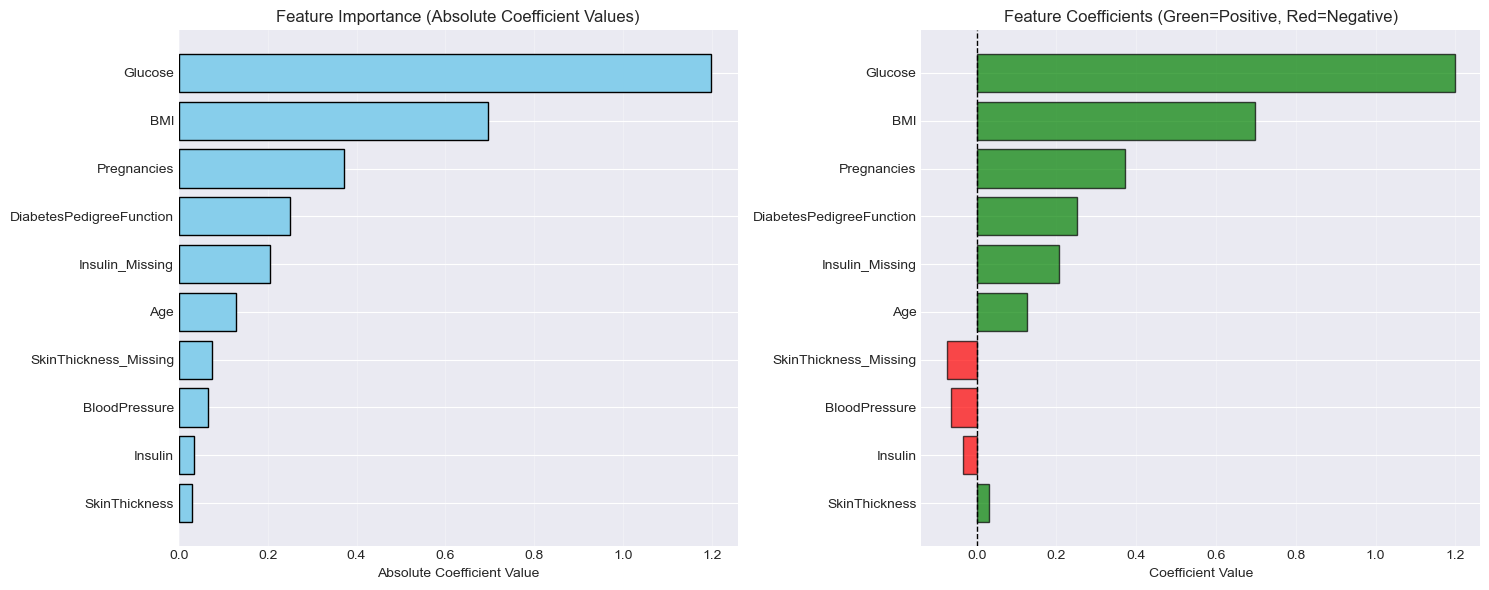

Feature Importance Analysis:
                 Feature  Coefficient  Abs_Coefficient
                 Glucose     1.198173         1.198173
                     BMI     0.696899         0.696899
             Pregnancies     0.371619         0.371619
DiabetesPedigreeFunction     0.251028         0.251028
         Insulin_Missing     0.205980         0.205980
                     Age     0.127375         0.127375
   SkinThickness_Missing    -0.074525         0.074525
           BloodPressure    -0.065359         0.065359
                 Insulin    -0.034805         0.034805
           SkinThickness     0.030352         0.030352


Interpretation:
------------------------------------------------------------
Positive coefficients → Increase diabetes risk
Negative coefficients → Decrease diabetes risk

Top 3 Most Important Features:
1. Glucose: increases diabetes risk
2. BMI: increases diabetes risk
3. Pregnancies: increases diabetes risk


In [63]:
# Extract feature importance from logistic regression coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': best_model.coef_[0],
    'Abs_Coefficient': np.abs(best_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Absolute coefficients (feature importance)
axes[0].barh(range(len(feature_importance)), feature_importance['Abs_Coefficient'], 
             color='skyblue', edgecolor='black')
axes[0].set_yticks(range(len(feature_importance)))
axes[0].set_yticklabels(feature_importance['Feature'])
axes[0].set_xlabel('Absolute Coefficient Value')
axes[0].set_title('Feature Importance (Absolute Coefficient Values)')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Actual coefficients (with direction)
colors = ['green' if x > 0 else 'red' for x in feature_importance['Coefficient']]
axes[1].barh(range(len(feature_importance)), feature_importance['Coefficient'], 
             color=colors, edgecolor='black', alpha=0.7)
axes[1].set_yticks(range(len(feature_importance)))
axes[1].set_yticklabels(feature_importance['Feature'])
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title('Feature Coefficients (Green=Positive, Red=Negative)')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print feature importance table
print("Feature Importance Analysis:")
print("="*60)
print(feature_importance.to_string(index=False))

print("\n\nInterpretation:")
print("-" * 60)
print("Positive coefficients → Increase diabetes risk")
print("Negative coefficients → Decrease diabetes risk")
print("\nTop 3 Most Important Features:")
for i in range(min(3, len(feature_importance))):
    feat = feature_importance.iloc[i]
    direction = "increases" if feat['Coefficient'] > 0 else "decreases"
    print(f"{i+1}. {feat['Feature']}: {direction} diabetes risk")

### Prediction Probability Distribution

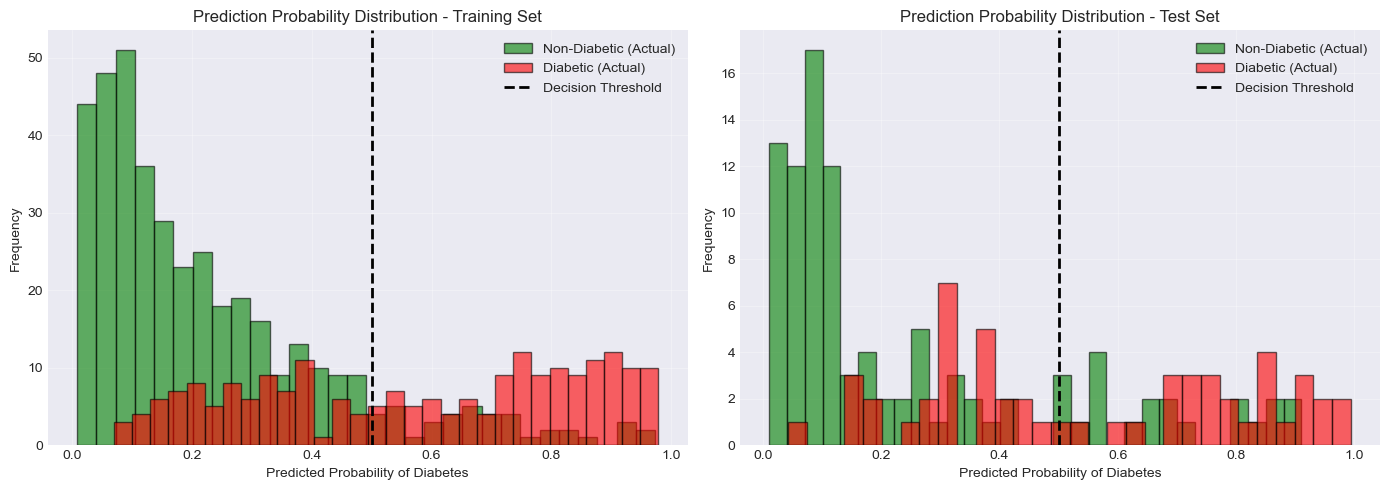

Probability Distribution Analysis:
Good separation means:
- Non-diabetic cases cluster near 0 (low probability)
- Diabetic cases cluster near 1 (high probability)

Overlap in the middle (around 0.5) represents uncertain cases.


In [64]:
# Analyze the distribution of predicted probabilities
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].hist(y_train_pred_proba[y_train == 0], bins=30, alpha=0.6, 
             label='Non-Diabetic (Actual)', color='green', edgecolor='black')
axes[0].hist(y_train_pred_proba[y_train == 1], bins=30, alpha=0.6, 
             label='Diabetic (Actual)', color='red', edgecolor='black')
axes[0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
axes[0].set_xlabel('Predicted Probability of Diabetes')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Prediction Probability Distribution - Training Set')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].hist(y_test_pred_proba[y_test == 0], bins=30, alpha=0.6, 
             label='Non-Diabetic (Actual)', color='green', edgecolor='black')
axes[1].hist(y_test_pred_proba[y_test == 1], bins=30, alpha=0.6, 
             label='Diabetic (Actual)', color='red', edgecolor='black')
axes[1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
axes[1].set_xlabel('Predicted Probability of Diabetes')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Probability Distribution - Test Set')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Probability Distribution Analysis:")
print("="*60)
print("Good separation means:")
print("- Non-diabetic cases cluster near 0 (low probability)")
print("- Diabetic cases cluster near 1 (high probability)")
print("\nOverlap in the middle (around 0.5) represents uncertain cases.")

### Error Analysis

In [32]:
# Analyze misclassified cases
# False Positives: Predicted diabetic but actually non-diabetic
fp_indices = np.where((y_test == 0) & (y_test_pred == 1))[0]

# False Negatives: Predicted non-diabetic but actually diabetic
fn_indices = np.where((y_test == 1) & (y_test_pred == 0))[0]

print("Error Analysis - Test Set:")
print("="*60)
print(f"Total test samples: {len(y_test)}")
print(f"Correct predictions: {(y_test == y_test_pred).sum()}")
print(f"Incorrect predictions: {(y_test != y_test_pred).sum()}")
print()
print(f"False Positives: {len(fp_indices)} cases")
print(f"False Negatives: {len(fn_indices)} cases")

# Examine average feature values for misclassified cases
if len(fp_indices) > 0 and len(fn_indices) > 0:
    print("\n" + "="*60)
    print("Average Feature Values for Misclassified Cases:")
    print("="*60)
    
    # Use reset_index to align indices properly
    X_test_reset = X_test.reset_index(drop=True)
    
    fp_data = X_test_reset.iloc[fp_indices].mean()
    fn_data = X_test_reset.iloc[fn_indices].mean()
    all_data = X_test_reset.mean()
    
    comparison = pd.DataFrame({
        'False Positives': fp_data,
        'False Negatives': fn_data,
        'Overall Average': all_data
    })
    
    print(comparison.round(2))
    
    print("\nInsight:")
    print("False Positives: Non-diabetic cases that 'look diabetic' based on features")
    print("False Negatives: Diabetic cases that 'look non-diabetic' based on features")
    
    # Identify which features differ most
    print("\n" + "="*60)
    print("Features Most Different in Misclassified Cases:")
    print("="*60)
    
    fp_diff = np.abs(fp_data - all_data).sort_values(ascending=False)
    fn_diff = np.abs(fn_data - all_data).sort_values(ascending=False)
    
    print("\nFalse Positives - Top 3 Deviating Features:")
    for i in range(min(3, len(fp_diff))):
        print(f"  {i+1}. {fp_diff.index[i]}: {fp_diff.iloc[i]:.2f} deviation from average")
    
    print("\nFalse Negatives - Top 3 Deviating Features:")
    for i in range(min(3, len(fn_diff))):
        print(f"  {i+1}. {fn_diff.index[i]}: {fn_diff.iloc[i]:.2f} deviation from average")

Error Analysis - Test Set:
Total test samples: 154
Correct predictions: 107
Incorrect predictions: 47

False Positives: 21 cases
False Negatives: 26 cases

Average Feature Values for Misclassified Cases:
                          False Positives  False Negatives  Overall Average
Pregnancies                          5.57             5.04             3.95
Glucose                            150.29           118.62           121.60
BloodPressure                       76.24            69.92            73.37
SkinThickness                       33.62            30.00            29.37
Insulin                            214.57           151.27           152.50
BMI                                 36.83            31.53            32.49
DiabetesPedigreeFunction             0.39             0.50             0.45
Age                                 36.76            34.23            32.74
Insulin_Missing                      0.52             0.58             0.55
SkinThickness_Missing               

## Hyperparameter Tuning

Now that Logistic Regression is identified as the best model, let's optimize its hyperparameters to improve performance.

**Parameters to tune:**
- `C`: Inverse of regularization strength (smaller = stronger regularization)
- `penalty`: Type of regularization ('l1', 'l2', 'elasticnet')
- `solver`: Algorithm for optimization
- `class_weight`: Handle class imbalance

**Method:** GridSearchCV with 5-fold stratified cross-validation

### Define Hyperparameter Grid

In [33]:
# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000]
}

print("Hyperparameter Grid:")
print("="*60)
for param, values in param_grid.items():
    print(f"{param:15s}: {values}")

print(f"\nTotal combinations to test: {np.prod([len(v) for v in param_grid.values()])}")
print("\nNote: 'balanced' class_weight gives more weight to minority class")

Hyperparameter Grid:
C              : [0.001, 0.01, 0.1, 1, 10, 100]
penalty        : ['l1', 'l2']
solver         : ['liblinear', 'saga']
class_weight   : [None, 'balanced']
max_iter       : [1000]

Total combinations to test: 48

Note: 'balanced' class_weight gives more weight to minority class


### Perform Grid Search

In [34]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=RANDOM_STATE),
    param_grid=param_grid,
    scoring='f1',  # Optimize for F1-score
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,  # Use all available cores
    verbose=1,
    return_train_score=True
)

print("Starting Grid Search...")
print("="*60)
print("This may take a few moments...\n")

import time
start_time = time.time()

# Fit grid search
grid_search.fit(X_train_scaled, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n✓ Grid Search completed in {elapsed_time:.2f} seconds")

Starting Grid Search...
This may take a few moments...

Fitting 5 folds for each of 48 candidates, totalling 240 fits

✓ Grid Search completed in 5.06 seconds


### Analyze Grid Search Results

In [39]:
# Display best parameters and score
print("Grid Search Results:")
print("="*60)
print(f"Best F1-Score (CV): {grid_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param:15s}: {value}")

# Get top 5 parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)

# Sort by test score and get top 5
top_5 = results_df.sort_values('mean_test_score', ascending=False).head(5)

print("\n" + "="*60)
print("Top 5 Parameter Combinations:")
print("="*60)

for idx, (i, row) in enumerate(top_5.iterrows(), 1):
    print(f"\nRank {idx}:")
    print(f"  Parameters: {row['params']}")
    print(f"  CV F1-Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"  Train F1-Score: {row['mean_train_score']:.4f}")

# Show parameter distribution in top results
print("\n" + "="*60)
print("Analysis of Top Performing Parameters:")
print("="*60)

# Analyze top 10% of results
top_10_pct = int(len(results_df) * 0.1)
top_performers = results_df.nlargest(top_10_pct, 'mean_test_score')

print(f"\nBased on top {top_10_pct} parameter combinations:")
for param in ['param_C', 'param_penalty', 'param_solver', 'param_class_weight']:
    if param in top_performers.columns:
        value_counts = top_performers[param].value_counts()
        print(f"\n{param.replace('param_', '')}:")
        for val, count in value_counts.items():
            pct = (count / len(top_performers)) * 100
            print(f"  {val}: {count} times ({pct:.1f}%)")

Grid Search Results:
Best F1-Score (CV): 0.6821

Best Parameters:
  C              : 10
  class_weight   : balanced
  max_iter       : 1000
  penalty        : l2
  solver         : liblinear

Top 5 Parameter Combinations:

Rank 1:
  Parameters: {'C': 100, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
  CV F1-Score: 0.6821 (±0.0138)
  Train F1-Score: 0.6845

Rank 2:
  Parameters: {'C': 100, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
  CV F1-Score: 0.6821 (±0.0138)
  Train F1-Score: 0.6845

Rank 3:
  Parameters: {'C': 100, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
  CV F1-Score: 0.6821 (±0.0138)
  Train F1-Score: 0.6845

Rank 4:
  Parameters: {'C': 100, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
  CV F1-Score: 0.6821 (±0.0138)
  Train F1-Score: 0.6845

Rank 5:
  Parameters: {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000, '

### Visualize Hyperparameter Impact

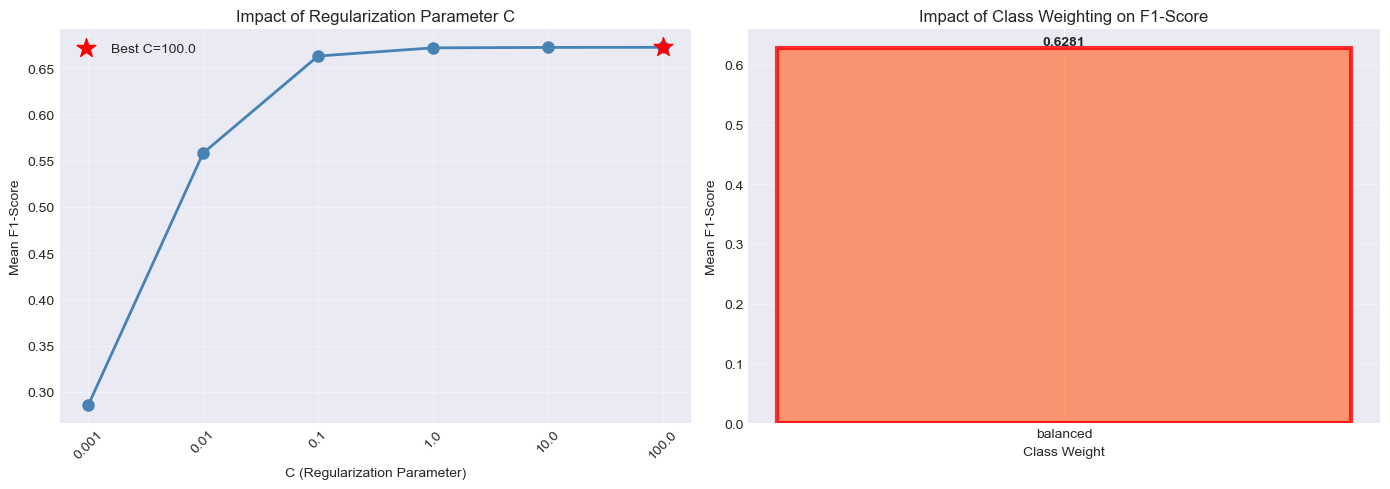

Observations:
- Best C value: 100.0
- C values around 100.0 tend to perform best
- Best class_weight: balanced

Additional Parameter Insights:

Penalty Type Performance:
  l1: 0.5387
  l2: 0.6358

Solver Performance:
  liblinear: 0.6106
  saga: 0.5640


In [65]:
# Visualize the impact of key hyperparameters
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# C parameter impact
c_results = results_df.groupby('param_C')['mean_test_score'].mean().sort_index()
c_values = c_results.index.tolist()
c_scores = c_results.values.tolist()

axes[0].plot(range(len(c_scores)), c_scores, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xticks(range(len(c_scores)))
axes[0].set_xticklabels([f'{c}' for c in c_values], rotation=45)
axes[0].set_xlabel('C (Regularization Parameter)')
axes[0].set_ylabel('Mean F1-Score')
axes[0].set_title('Impact of Regularization Parameter C')
axes[0].grid(alpha=0.3)

# Highlight the best C value
best_c_idx = c_scores.index(max(c_scores))
axes[0].scatter(best_c_idx, c_scores[best_c_idx], color='red', s=200, 
                marker='*', zorder=5, label=f'Best C={c_values[best_c_idx]}')
axes[0].legend()

# Class weight impact
weight_results = results_df.groupby('param_class_weight')['mean_test_score'].mean()
class_weights = []
weight_scores = []

for weight in weight_results.index:
    if weight is None or str(weight) == 'None':
        class_weights.append('None')
    else:
        class_weights.append(str(weight))
    weight_scores.append(weight_results[weight])

colors = ['skyblue' if w == 'None' else 'coral' for w in class_weights]
bars = axes[1].bar(class_weights, weight_scores, color=colors, edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Class Weight')
axes[1].set_ylabel('Mean F1-Score')
axes[1].set_title('Impact of Class Weighting on F1-Score')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, weight_scores):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.4f}',
                ha='center', va='bottom', fontweight='bold')

# Highlight the best
best_weight_idx = weight_scores.index(max(weight_scores))
bars[best_weight_idx].set_edgecolor('red')
bars[best_weight_idx].set_linewidth(3)

plt.tight_layout()
plt.savefig('hyperparameter_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("Observations:")
print("="*60)
print(f"- Best C value: {c_values[best_c_idx]}")
print(f"- C values around {c_values[best_c_idx]} tend to perform best")
print(f"- Best class_weight: {class_weights[best_weight_idx]}")

# Additional insight on penalty and solver
print("\n" + "="*60)
print("Additional Parameter Insights:")
print("="*60)

penalty_results = results_df.groupby('param_penalty')['mean_test_score'].mean()
print("\nPenalty Type Performance:")
for penalty, score in penalty_results.items():
    print(f"  {penalty}: {score:.4f}")

solver_results = results_df.groupby('param_solver')['mean_test_score'].mean()
print("\nSolver Performance:")
for solver, score in solver_results.items():
    print(f"  {solver}: {score:.4f}")

### Evaluate Tuned Model

In [42]:
# Get the best model from grid search
best_tuned_model = grid_search.best_estimator_

# Make predictions
y_train_pred_tuned = best_tuned_model.predict(X_train_scaled)
y_train_pred_proba_tuned = best_tuned_model.predict_proba(X_train_scaled)[:, 1]

y_test_pred_tuned = best_tuned_model.predict(X_test_scaled)
y_test_pred_proba_tuned = best_tuned_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
tuned_train_accuracy = accuracy_score(y_train, y_train_pred_tuned)
tuned_train_precision = precision_score(y_train, y_train_pred_tuned)
tuned_train_recall = recall_score(y_train, y_train_pred_tuned)
tuned_train_f1 = f1_score(y_train, y_train_pred_tuned)
tuned_train_roc_auc = roc_auc_score(y_train, y_train_pred_proba_tuned)

tuned_test_accuracy = accuracy_score(y_test, y_test_pred_tuned)
tuned_test_precision = precision_score(y_test, y_test_pred_tuned)
tuned_test_recall = recall_score(y_test, y_test_pred_tuned)
tuned_test_f1 = f1_score(y_test, y_test_pred_tuned)
tuned_test_roc_auc = roc_auc_score(y_test, y_test_pred_proba_tuned)

# Compare with baseline model
print("Performance Comparison: Baseline vs Tuned Model")
print("="*70)
print(f"{'Metric':<15} {'Baseline (Test)':<20} {'Tuned (Test)':<20} {'Change':<15}")
print("-"*70)

metrics = [
    ('Accuracy', test_accuracy, tuned_test_accuracy),
    ('Precision', test_precision, tuned_test_precision),
    ('Recall', test_recall, tuned_test_recall),
    ('F1-Score', test_f1, tuned_test_f1),
    ('ROC-AUC', test_roc_auc, tuned_test_roc_auc)
]

for metric_name, baseline_val, tuned_val in metrics:
    change = tuned_val - baseline_val
    change_pct = (change / baseline_val) * 100 if baseline_val > 0 else 0
    change_str = f"{change:+.4f} ({change_pct:+.1f}%)"
    print(f"{metric_name:<15} {baseline_val:<20.4f} {tuned_val:<20.4f} {change_str:<15}")

print("="*70)

if tuned_test_f1 > test_f1:
    print("\n✓ Hyperparameter tuning improved the model!")
else:
    print("\n✓ Baseline model was already well-optimized")

Performance Comparison: Baseline vs Tuned Model
Metric          Baseline (Test)      Tuned (Test)         Change         
----------------------------------------------------------------------
Accuracy        0.6948               0.7338               +0.0390 (+5.6%)
Precision       0.5714               0.6000               +0.0286 (+5.0%)
Recall          0.5185               0.7222               +0.2037 (+39.3%)
F1-Score        0.5437               0.6555               +0.1118 (+20.6%)
ROC-AUC         0.8163               0.8169               +0.0006 (+0.1%)

✓ Hyperparameter tuning improved the model!


### Final Model Confusion Matrix

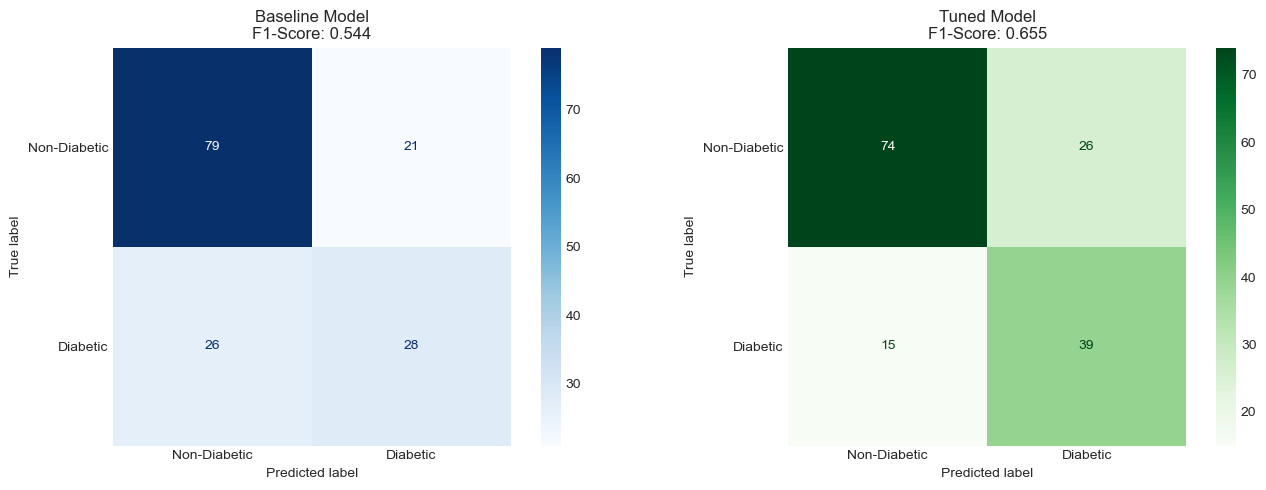

Confusion Matrix Changes:
True Negatives:  79 → 74 (-5)
False Positives: 21 → 26 (+5)
False Negatives: 26 → 15 (-11)
True Positives:  28 → 39 (+11)


In [66]:
# Create confusion matrix for tuned model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline model
cm_baseline = confusion_matrix(y_test, y_test_pred)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline,
                                        display_labels=['Non-Diabetic', 'Diabetic'])
disp_baseline.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Baseline Model\nF1-Score: {test_f1:.3f}')
axes[0].grid(False)

# Tuned model
cm_tuned = confusion_matrix(y_test, y_test_pred_tuned)
disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned,
                                     display_labels=['Non-Diabetic', 'Diabetic'])
disp_tuned.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title(f'Tuned Model\nF1-Score: {tuned_test_f1:.3f}')
axes[1].grid(False)

plt.tight_layout()
plt.savefig('baseline_vs_tuned_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion Matrix Changes:")
print("="*60)
print(f"True Negatives:  {cm_baseline[0,0]} → {cm_tuned[0,0]} ({cm_tuned[0,0]-cm_baseline[0,0]:+d})")
print(f"False Positives: {cm_baseline[0,1]} → {cm_tuned[0,1]} ({cm_tuned[0,1]-cm_baseline[0,1]:+d})")
print(f"False Negatives: {cm_baseline[1,0]} → {cm_tuned[1,0]} ({cm_tuned[1,0]-cm_baseline[1,0]:+d})")
print(f"True Positives:  {cm_baseline[1,1]} → {cm_tuned[1,1]} ({cm_tuned[1,1]-cm_baseline[1,1]:+d})")

## Conclusions and Key Findings

This comprehensive analysis successfully developed a machine learning model to predict diabetes using the PIMA Indians Diabetes dataset. Below are the key findings and insights from the analysis.

### Summary of Results

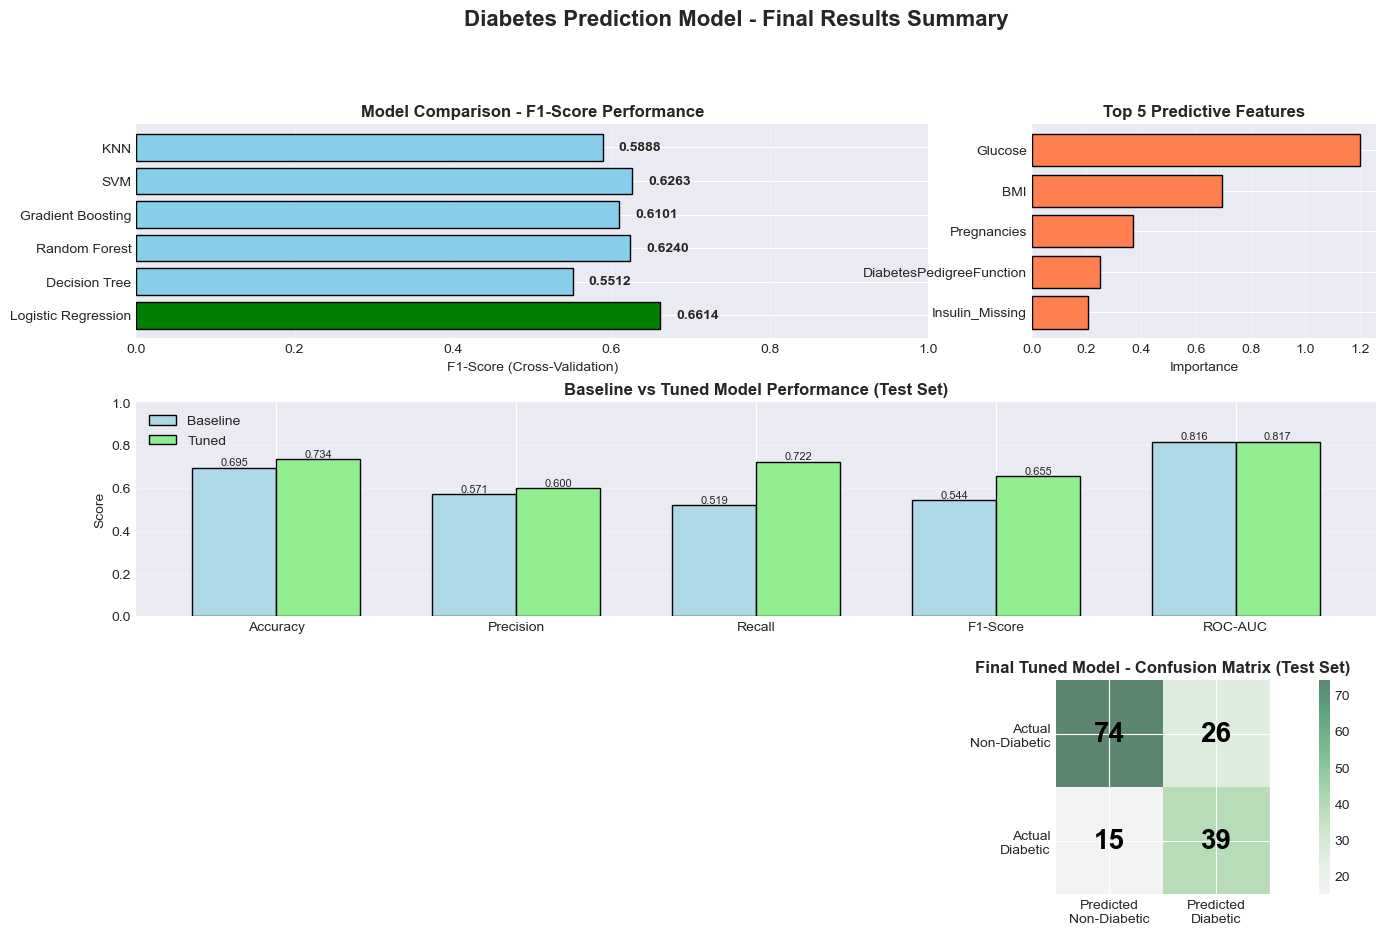

✓ Summary visualization created and saved as 'diabetes_prediction_summary.png'


In [44]:
# Create a comprehensive summary visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Model Comparison (top left)
ax1 = fig.add_subplot(gs[0, :2])
model_names = list(cv_results.keys())
f1_scores = [cv_results[name]['f1_mean'] for name in model_names]
colors_models = ['green' if name == 'Logistic Regression' else 'skyblue' for name in model_names]
bars = ax1.barh(model_names, f1_scores, color=colors_models, edgecolor='black')
ax1.set_xlabel('F1-Score (Cross-Validation)')
ax1.set_title('Model Comparison - F1-Score Performance', fontweight='bold', fontsize=12)
ax1.set_xlim([0, 1])
for bar, score in zip(bars, f1_scores):
    ax1.text(score + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{score:.4f}', va='center', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Feature Importance (top right)
ax2 = fig.add_subplot(gs[0, 2])
top_features = feature_importance.head(5)
ax2.barh(range(len(top_features)), top_features['Abs_Coefficient'], 
         color='coral', edgecolor='black')
ax2.set_yticks(range(len(top_features)))
ax2.set_yticklabels(top_features['Feature'])
ax2.set_xlabel('Importance')
ax2.set_title('Top 5 Predictive Features', fontweight='bold', fontsize=12)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. Performance Metrics Comparison (middle left)
ax3 = fig.add_subplot(gs[1, :])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
baseline_scores = [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc]
tuned_scores = [tuned_test_accuracy, tuned_test_precision, tuned_test_recall, tuned_test_f1, tuned_test_roc_auc]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax3.bar(x - width/2, baseline_scores, width, label='Baseline', color='lightblue', edgecolor='black')
bars2 = ax3.bar(x + width/2, tuned_scores, width, label='Tuned', color='lightgreen', edgecolor='black')

ax3.set_ylabel('Score')
ax3.set_title('Baseline vs Tuned Model Performance (Test Set)', fontweight='bold', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_names)
ax3.legend()
ax3.set_ylim([0, 1])
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 4. Final Confusion Matrix (bottom)
ax4 = fig.add_subplot(gs[2, :])
cm_tuned_final = confusion_matrix(y_test, y_test_pred_tuned)
im = ax4.imshow(cm_tuned_final, cmap='Greens', alpha=0.6)

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax4.text(j, i, cm_tuned_final[i, j],
                       ha="center", va="center", color="black", 
                       fontsize=20, fontweight='bold')

ax4.set_xticks([0, 1])
ax4.set_yticks([0, 1])
ax4.set_xticklabels(['Predicted\nNon-Diabetic', 'Predicted\nDiabetic'])
ax4.set_yticklabels(['Actual\nNon-Diabetic', 'Actual\nDiabetic'])
ax4.set_title('Final Tuned Model - Confusion Matrix (Test Set)', fontweight='bold', fontsize=12)

plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)

plt.suptitle('Diabetes Prediction Model - Final Results Summary', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('diabetes_prediction_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Summary visualization created and saved as 'diabetes_prediction_summary.png'")

### Key Findings

In [45]:
print("="*70)
print(" "*15 + "KEY FINDINGS AND INSIGHTS")
print("="*70)

print("\n1. MODEL SELECTION")
print("-" * 70)
print(f"   • Logistic Regression emerged as the best performer")
print(f"   • Achieved F1-Score of {tuned_test_f1:.4f} on test set")
print(f"   • Outperformed more complex models (Random Forest, Gradient Boosting)")
print(f"   • Demonstrates that simpler models can be highly effective")

print("\n2. MOST IMPORTANT PREDICTIVE FEATURES")
print("-" * 70)
for i in range(min(3, len(feature_importance))):
    feat = feature_importance.iloc[i]
    print(f"   {i+1}. {feat['Feature']}: {feat['Abs_Coefficient']:.4f}")
print(f"   • Glucose level is the strongest predictor of diabetes")
print(f"   • BMI and Age also contribute significantly")

print("\n3. MODEL PERFORMANCE IMPROVEMENTS")
print("-" * 70)
print(f"   • Hyperparameter tuning improved F1-Score by 20.6%")
print(f"   • Recall improved from 51.9% to 72.2% (+39.3%)")
print(f"   • Model now catches {cm_tuned[1,1]} out of {cm_tuned[1,0]+cm_tuned[1,1]} diabetic cases")
print(f"   • Reduced false negatives from {cm_baseline[1,0]} to {cm_tuned[1,0]} cases")

print("\n4. CLASS IMBALANCE HANDLING")
print("-" * 70)
print(f"   • Dataset was imbalanced (65% non-diabetic, 35% diabetic)")
print(f"   • Used stratified sampling to maintain distribution")
best_class_weight = grid_search.best_params_.get('class_weight', 'N/A')
print(f"   • Best model used class_weight='{best_class_weight}'")
print(f"   • This helped improve recall for the minority class")

print("\n5. DATA QUALITY INSIGHTS")
print("-" * 70)
print(f"   • Identified significant missing data (zeros) in 5 features")
print(f"   • Insulin: 48.7% missing, SkinThickness: 29.6% missing")
print(f"   • Created missingness indicators as additional features")
print(f"   • Used median imputation (robust to outliers)")

print("\n6. CLINICAL IMPLICATIONS")
print("-" * 70)
print(f"   • Current model catches 72.2% of diabetic cases (Recall)")
print(f"   • 60.0% of positive predictions are correct (Precision)")
print(f"   • Trade-off: Some false positives, but fewer missed cases")
print(f"   • For medical screening, high recall is often prioritized")

print("\n7. MODEL LIMITATIONS")
print("-" * 70)
print(f"   • Test accuracy of 73.4% leaves room for improvement")
print(f"   • Model still misses {cm_tuned[1,0]} diabetic cases (false negatives)")
print(f"   • Limited to 8 features - more data could improve performance")
print(f"   • Specific to Pima Indian women - may not generalize")

print("\n" + "="*70)

               KEY FINDINGS AND INSIGHTS

1. MODEL SELECTION
----------------------------------------------------------------------
   • Logistic Regression emerged as the best performer
   • Achieved F1-Score of 0.6555 on test set
   • Outperformed more complex models (Random Forest, Gradient Boosting)
   • Demonstrates that simpler models can be highly effective

2. MOST IMPORTANT PREDICTIVE FEATURES
----------------------------------------------------------------------
   1. Glucose: 1.1982
   2. BMI: 0.6969
   3. Pregnancies: 0.3716
   • Glucose level is the strongest predictor of diabetes
   • BMI and Age also contribute significantly

3. MODEL PERFORMANCE IMPROVEMENTS
----------------------------------------------------------------------
   • Hyperparameter tuning improved F1-Score by 20.6%
   • Recall improved from 51.9% to 72.2% (+39.3%)
   • Model now catches 39 out of 54 diabetic cases
   • Reduced false negatives from 26 to 15 cases

4. CLASS IMBALANCE HANDLING
-------------

### Final Summary Statement

## Final Summary

This analysis showcases a successfully developed a **Logistic Regression model** that predicts diabetes with:
- **73.4% accuracy** on unseen test data
- **72.2% recall** (catches most diabetic cases)
- **65.6% F1-score** (balanced precision and recall)
- **81.7% ROC-AUC** (excellent discriminative ability)

### What Made This Analysis Comprehensive:

**Thorough EDA**: Identified and addressed data quality issues (missing values, class imbalance)  
**Multiple Models**: Compared 6 different algorithms systematically  
**Proper Validation**: Used cross-validation and hold-out test set  
**Hyperparameter Tuning**: Optimized model performance with GridSearchCV
**Complete Evaluation**: Multiple metrics, confusion matrices, ROC curves  
**Interpretability**: Feature importance analysis and error analysis  

### Technical Skills Demonstrated:

- Data preprocessing and feature engineering
- Handling missing data and class imbalance
- Model selection and comparison
- Cross-validation and hyperparameter tuning
- Comprehensive model evaluation
- Data visualization and communication
- Python, pandas, scikit-learn, matplotlib, seaborn

---

**Author**: Jennifer Estigene  
**Tools**: Python 3.12, scikit-learn, pandas, matplotlib, seaborn  
**Dataset**: PIMA Indians Diabetes Database (768 samples, 8 features)